# Lab Assignment 2

**Submission deadline:**
* **Regular problems: last lab session before or on Monday, 18.11.19**
* **Bonus problems: deadline for Lab Assignment 3**

**Points: 12 + 7 bonus points**

Please note: some of the assignments are tedious or boring if you are already a NumPy ninja. The bonus problems were designed to give you a more satisfying alternative.

The assignment is in the form of a Jupyter notebook. We will be using [Google Colab](https://colab.research.google.com) to solve it. Below you will find a "Setup" section. Follow instructions from this paragraph to download the notebook and open it using [Google Colab](https://colab.research.google.com). 

Your goal is to solve problems posted below. Whenever possible, add your solutions to the notebook.

Please email us about any problems with it - we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

In [14]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

In [20]:
# Standard IPython notebook imports
%matplotlib inline

import os

from io import StringIO
import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import scipy.stats as sstats

import seaborn as sns
import sklearn.tree
import sklearn.ensemble

import graphviz

import re


# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat

sns.set_style('whitegrid')

ModuleNotFoundError: No module named 'httpimport'

# Problem 1 [2p] Naive Bayes Classifier

The Bayes' theorem allows us to construct a classifier in which we
model how the data is generated. Here we will describe a
simple and popular example of such a classifier called the naive
Bayes classifier.  Despite its simplicity It is quite effective for
classification of text documents (e.g. as spam and non-spam).

Let a document be a sequence of words $D=W_1,W_2,\ldots,W_n$ 
We will model generation of text documents as a two-stage process.
First, document category $C_j$ is drawn at random with probability
$p(C_j)$, also called the *a priori* probability.
To define the class-conditional probability
$p(D|C_j)$, we will make a simplifying (naive)
assumption, that every word in the document is drawn independently at
random with probability $p(W_i|C)$:

\begin{equation*}
  p(D|C_j) = p(W_1,W_2,\ldots,W_n | C_j) \approx p(W_1|C_j)p(W_2|C_j)\ldots p(W_n|C_j).
\end{equation*}

To infer the class of a document we apply the Bayes theorem:
\begin{equation*}   p(C_j|D) = \frac{p(D|C_j)p(C_j)}{p(D)} = \frac{p(C_j)p(W_1|C_j)p(W_2|C_j)\ldots p(W_n|C_j)}{p(D)}.
\end{equation*}
Please note that since we assumed only a finite number of classes,
we can compute the term $p(D)$ by making sure that the *a
posteriori probabilities* $p(C_j|D)$ sum to $1$ over all classes.

In this exercise we will try to mimic the language-guessing feature
of [Google Translate](https://translate.google.com/), although
on a much smaller scale.  We are given an input which is a
lower-case sequence of characters (such as *"some people like
pineapple on their pizza"*), and we determine whether the
sequence's language is English, Polish or Spanish.
We will treat each character as a separate observation.
The numbers are taken from [Wikipedia article on letter frequency](https://en.wikipedia.org/wiki/Letter_frequency#Relative_frequencies_of_letters_in_other_languages). We display the first few rows:

In [19]:
wiki_table = u"""English|French|German|Spanish|Portuguese|Esperanto|Italian|Turkish|Swedish|Polish|Dutch|Danish|Icelandic|Finnish|Czech
a|8.167|7.636|6.516|11.525|14.634|12.117|11.745|12.920|9.383|10.503|7.486|6.025|10.110|12.217|8.421
b|1.492|0.901|1.886|2.215|1.043|0.980|0.927|2.844|1.535|1.740|1.584|2.000|1.043|0.281|0.822
c|2.782|3.260|2.732|4.019|3.882|0.776|4.501|1.463|1.486|3.895|1.242|0.565|0|0.281|0.740
d|4.253|3.669|5.076|5.010|4.992|3.044|3.736|5.206|4.702|3.725|5.933|5.858|1.575|1.043|3.475
e|12.702|14.715|16.396|12.181|12.570|8.995|11.792|9.912|10.149|7.352|18.91|15.453|6.418|7.968|7.562
f|2.228|1.066|1.656|0.692|1.023|1.037|1.153|0.461|2.027|0.143|0.805|2.406|3.013|0.194|0.084
g|2.015|0.866|3.009|1.768|1.303|1.171|1.644|1.253|2.862|1.731|3.403|4.077|4.241|0.392|0.092
h|6.094|0.737|4.577|0.703|0.781|0.384|0.636|1.212|2.090|1.015|2.380|1.621|1.871|1.851|1.356
i|6.966|7.529|6.550|6.247|6.186|10.012|10.143|9.600|5.817|8.328|6.499|6.000|7.578|10.817|6.073
j|0.153|0.613|0.268|0.493|0.397|3.501|0.011|0.034|0.614|1.836|1.46|0.730|1.144|2.042|1.433
k|0.772|0.049|1.417|0.011|0.015|4.163|0.009|5.683|3.140|2.753|2.248|3.395|3.314|4.973|2.894
l|4.025|5.456|3.437|4.967|2.779|6.104|6.510|5.922|5.275|2.564|3.568|5.229|4.532|5.761|3.802
m|2.406|2.968|2.534|3.157|4.738|2.994|2.512|3.752|3.471|2.515|2.213|3.237|4.041|3.202|2.446
n|6.749|7.095|9.776|6.712|4.446|7.955|6.883|7.987|8.542|6.237|10.032|7.240|7.711|8.826|6.468
o|7.507|5.796|2.594|8.683|9.735|8.779|9.832|2.976|4.482|6.667|6.063|4.636|2.166|5.614|6.695
p|1.929|2.521|0.670|2.510|2.523|2.755|3.056|0.886|1.839|2.445|1.57|1.756|0.789|1.842|1.906
q|0.095|1.362|0.018|0.877|1.204|0|0.505|0|0.020|0|0.009|0.007|0|0.013|0.001
r|5.987|6.693|7.003|6.871|6.530|5.914|6.367|7.722|8.431|5.243|6.411|8.956|8.581|2.872|4.799
s|6.327|7.948|7.270|7.977|6.805|6.092|4.981|3.014|6.590|5.224|3.73|5.805|5.630|7.862|5.212
t|9.056|7.244|6.154|4.632|4.336|5.276|5.623|3.314|7.691|2.475|6.79|6.862|4.953|8.750|5.727
u|2.758|6.311|4.166|2.927|3.639|3.183|3.011|3.235|1.919|2.062|1.99|1.979|4.562|5.008|2.160
v|0.978|1.838|0.846|1.138|1.575|1.904|2.097|0.959|2.415|0.012|2.85|2.332|2.437|2.250|5.344
w|2.360|0.074|1.921|0.017|0.037|0|0.033|0|0.142|5.813|1.52|0.069|0|0.094|0.016
x|0.150|0.427|0.034|0.215|0.253|0|0.003|0|0.159|0.004|0.036|0.028|0.046|0.031|0.027
y|1.974|0.128|0.039|1.008|0.006|0|0.020|3.336|0.708|3.206|0.035|0.698|0.900|1.745|1.043
z|0.074|0.326|1.134|0.467|0.470|0.494|1.181|1.500|0.070|4.852|1.39|0.034|0|0.051|1.503
à|0|0.486|0|0|0.072|0|0.635|0|0|0|0|0|0|0|0
â|0|0.051|0|0|0.562|0|0|0|0|0|0|0|0|0|0
á|0|0|0|0.502|0.118|0|0|0|0|0|0|0|1.799|0|0.867
å|0|0|0|0|0|0|0|0|1.338|0|0|1.190|0|0.003|0
ä|0|0|0.578|0|0|0|0|0|1.797|0|0|0|0|3.577|0
ã|0|0|0|0|0.733|0|0|0|0|0|0|0|0|0|0
ą|0|0|0|0|0|0|0|0|0|0.699|0|0|0|0|0
æ|0|0|0|0|0|0|0|0|0|0|0|0.872|0.867|0|0
œ|0|0.018|0|0|0|0|0|0|0|0|0|0|0|0|0
ç|0|0.085|0|0|0.530|0|0|1.156|0|0|0|0|0|0|0
ĉ|0|0|0|0|0|0.657|0|0|0|0|0|0|0|0|0
ć|0|0|0|0|0|0|0|0|0|0.743|0|0|0|0|0
č|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.462
ď|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.015
ð|0|0|0|0|0|0|0|0|0|0|0|0|4.393|0|0
è|0|0.271|0|0|0|0|0.263|0|0|0|0|0|0|0|0
é|0|1.504|0|0.433|0.337|0|0|0|0|0|0|0|0.647|0|0.633
ê|0|0.218|0|0|0.450|0|0|0|0|0|0|0|0|0|0
ë|0|0.008|0|0|0|0|0|0|0|0|0|0|0|0|0
ę|0|0|0|0|0|0|0|0|0|1.035|0|0|0|0|0
ě|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1.222
ĝ|0|0|0|0|0|0.691|0|0|0|0|0|0|0|0|0
ğ|0|0|0|0|0|0|0|1.125|0|0|0|0|0|0|0
ĥ|0|0|0|0|0|0.022|0|0|0|0|0|0|0|0|0
î|0|0.045|0|0|0|0|0|0|0|0|0|0|0|0|0
ì|0|0|0|0|0|0|0.030|0|0|0|0|0|0|0|0
í|0|0|0|0.725|0.132|0|0|0|0|0|0|0|1.570|0|1.643
ï|0|0.005|0|0|0|0|0|0|0|0|0|0|0|0|0
ı|0|0|0|0|0|0|0|5.114|0|0|0|0|0|0|0
ĵ|0|0|0|0|0|0.055|0|0|0|0|0|0|0|0|0
ł|0|0|0|0|0|0|0|0|0|2.109|0|0|0|0|0
ñ|0|0|0|0.311|0|0|0|0|0|0|0|0|0|0|0
ń|0|0|0|0|0|0|0|0|0|0.362|0|0|0|0|0
ň|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.007
ò|0|0|0|0|0|0|0.002|0|0|0|0|0|0|0|0
ö|0|0|0.443|0|0|0|0|0.777|1.305|0|0|0|0.777|0.444|0
ô|0|0.023|0|0|0.635|0|0|0|0|0|0|0|0|0|0
ó|0|0|0|0.827|0.296|0|0|0|0|1.141|0|0|0.994|0|0.024
õ|0|0|0|0|0.040|0|0|0|0|0|0|0|0|0|0
ø|0|0|0|0|0|0|0|0|0|0|0|0.939|0|0|0
ř|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.380
ŝ|0|0|0|0|0|0.385|0|0|0|0|0|0|0|0|0
ş|0|0|0|0|0|0|0|1.780|0|0|0|0|0|0|0
ś|0|0|0|0|0|0|0|0|0|0.814|0|0|0|0|0
š|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.688
ß|0|0|0.307|0|0|0|0|0|0|0|0|0|0|0|0
ť|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.006
þ|0|0|0|0|0|0|0|0|0|0|0|0|1.455|0|0
ù|0|0.058|0|0|0|0|0.166|0|0|0|0|0|0|0|0
ú|0|0|0|0.168|0.207|0|0|0|0|0|0|0|0.613|0|0.045
û|0|0.060|0|0|0|0|0|0|0|0|0|0|0|0|0
ŭ|0|0|0|0|0|0.520|0|0|0|0|0|0|0|0|0
ü|0|0|0.995|0.012|0.026|0|0|1.854|0|0|0|0|0|0|0
ů|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.204
ý|0|0|0|0|0|0|0|0|0|0|0|0|0.228|0|0.995
ź|0|0|0|0|0|0|0|0|0|0.078|0|0|0|0|0
ż|0|0|0|0|0|0|0|0|0|0.706|0|0|0|0|0
ž|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.721"""
df = pd.read_table(StringIO(wiki_table), sep='|', index_col=0)
df.head()

NameError: name 'pd' is not defined

Implement the language classifier and answer the following:

1. **[0.5p]** Naive Bayes can be implemented
    either by multiplying probabilities or by adding
    log-probabilities. Which one is better and why?

    Please type a short answer below.
2. **[1.5p]** What is the language of the following phrases, according to the classifier (below in a code cell)? Assume equal prior language probabilities $P(C)$.
3. **[bonus]** What happens when a Naive Bayes classifier
      is applied to a document with out-of-vocabulary words? Propose
      some solutions. Relate them to the concept of Bayesian
      priors discussed during the lecture. 

      This question will be discussed during Class Assignment 2.

Using log-probabilities is TODO because TODO.

In [10]:
# We can easiily manipulate the letter frequency table using Pandas
langs = list(df)
letters = list(df.index)
print('Languages:', ','.join(langs))
print('Letters:', ', '.join(letters))
print('P(ę|Polish) =', df.loc['ę', 'Polish'])

NameError: name 'df' is not defined

In [11]:
# The values are recentages of letter appearance, but curiously enough they don't
# sum to 100%.
print(f'\nTotal letter count by language:\n{df.sum(0)}')

# Normalize the data such that the letter frequencies add up to 1 for each language
df_norm = df.apply(lambda x : np.divide(x, df.sum(0)[x.name]))
print(f'\nAfter normalization:\n{df_norm.sum(0)}')

print(df_norm.head())

NameError: name 'df' is not defined

In [ ]:
def naive_bayes(sent, langs, df):
    """Returns the most probable language of a sentence"""
    
    # Try working with log-probabilities. 
    # to prevent taking log(0) you can e.g. add a very small amount (1e-100)
    # to each tabulated frequency.
    df_log = df.apply(lambda x : np.log(x + 1e-100))

    # normalize the sentence: remove spaces and punctuations, take lower case
    sent = re.sub(r'\W+', '', sent.lower())
    
    # TODO compute language probabilities and order from most to least probable
    log_probs = {}
    for lang in langs:
        s = np.sum([df_log[lang][c] for c in sent])
        log_probs[lang] = np.exp(s) / len(langs)
    
    values_sum = np.sum(list(log_probs.values()))

    for k, v in log_probs.items():
        log_probs[k] = v / values_sum
    return dict(sorted(log_probs.items(), key=lambda kv : kv[1], reverse=True))

In [ ]:
sentences = [
    "No dejes para mañana lo que puedas hacer hoy.",
    "Przed wyruszeniem w drogę należy zebrać drużynę.",
    "Żeby zrozumieć rekurencję, należy najpierw zrozumieć rekurencję.",
    "Si vale la pena hacerlo vale la pena hacerlo bien.",
    "Experience is what you get when you didn't get what you wanted.",
    "Należy prowokować intelekt, nie intelektualistów."]

for sent in sentences:
    print(f'{sent}:')
    for k, v in naive_bayes(sent, langs, df_norm).items():
        if v<1e-3:
            break
        print(f'{k}: {v:.3f}\t', end='')
    print('\n')

# Problem 2: Simple Kalman filtering [2p + 2b]

Oh no, someone has kidnapped you! You feel that you are in the trunk of a moving car. Luckily, you have your phone with GPS. Unfortunately, the GPS is noisy. You want to combine your estimate of your location by combining your prior belief about where you can be with the noisy GPS. You set out to implement a [1D Kalman filter](https://en.wikipedia.org/wiki/Kalman_filter).

Problem setup:
- your prior belief about the location is a Gaussian with mean 0 and some initial standard deviation $\mathcal{N}(0, \sigma_i)$
- the car moves in a brownian motion - each time step, it changes location by a normally distributed random amound sampled from $\mathcal{N}(0, \sigma_m)$
- each time step, you get a GPS reading which is sampled around your true (and sadly unknown to you ) location from $\mathcal{N}(\text{true loc}, \sigma_g)$

You want to use the following algorithm to track your location:

1. Initially, the PDF of your location is $p(x) = \mathcal{N}(x; \mu_l=0, \sigma_l=\sigma_i)$
2. For each time step, you update your belief about your location:
    1. $p(x)$ is updated due to according to the car movement distribution
    2. you use the Bayes formula to incorporate the GPS readout:
       $$
      p(x|\text{GPS readout}) = \frac{p(\text{GPS readout}|x)p(x)}
                                                           {p(\text{GPS readout})}
      $$
    3. you set $p(x) \gets p(x|\text{GPS readout})$ to be your prior belief about your locatin used during the next iteration.


NB: the GPS is actually very noisy, and Kalman filters are routinely used to fuse information from the GPS, accelerometers and odometry in practical applications, such as GPS navigation.

Hint: during the class assignments we have computed the pdf of
$$
p(x) = \mathcal{N}(x;\mu_1, \sigma_1)\mathcal{N}(x;\mu_2, \sigma_2)
$$
What disrtibution will the PDF belong to? Maybe you can simply compute the new mean and standard deviation?

#### Problem [.5p]

Implement below a simulator for your kidnapping, then fill in the code for plotting the true location and GPS readouts over time.

#### Problem [1.5p]

Implement a 1D Kalman filer using the algorithm stated above: maintian a probability distribution over your location, then at each timestep update it to account for car movement and GPS readouts.

Plot the estimated location along with its standard deviation against the true location from the simluator.

Experiemt with different setting for the standard deviations of the car's motion and the GPS. What happens if the simulator and the Kalman filter use different probability distributions?

#### Problem [2p bonus]

Suppose the car has a velocity, which is updated at each time step:
$$
\begin{split}
v &\gets v + \mathcal{N}(0, \sigma_v) \\
x &\gets x + v \\
\text{GPS readout} &= \mathcal{N}(x, \sigma_g) 
\end{split}
$$

Update the Kalman filter code to track both the car's location and velocity. You can assume that the initial velocity is exactly 0.

In [ ]:
def simulate(initial_sigma, motion_sigma, gps_sigma, n_steps):
    """Simulate a sequence of locations and noisy GPS measurements

    Args:
        initial_sigma, motion_sigma, gps_sigma: parameters of the simulation
        n_steps: number of timesteps

    Returns:
        a DataFrame with columns 'x' and 'gps' giving the true location and 
        gps readouts.
    """
    
    # Sample an initial location from the distribution ovetr the initial loc
    x = np.random.normal(0, initial_sigma)
    loc_hist = []
    for s in range(n_steps):
        # TODO: sample a new x and gps readout
        x += np.random.normal(0, motion_sigma)
        gps_readout = np.random.normal(x, gps_sigma)
        loc_hist.append((x, gps_readout))
    loc_df = pd.DataFrame(loc_hist, columns=['x', 'gps'])
    return loc_df


def kalman_predict(loc_df, initial_sigma, motion_sigma, gps_sigma):
    # Set our initial belief about our location
    prior_mu = 0
    prior_sigma = initial_sigma
    predictions = []
    for gps_readout in loc_df.gps:
        # expand the prior by the movement
        prior_sigma = np.sqrt(prior_sigma ** 2 + motion_sigma ** 2)
        # now do the bayes update
        # p(x) = P(x | GPS) = (P(GPS | x) * P(x)) / P(GPS)
        # P(GPS) ~ N(gps_readout, gps_sigma)
        posterior_mu = ((gps_readout * prior_sigma ** 2) + (prior_mu * gps_sigma ** 2)) / (prior_sigma ** 2 + gps_sigma ** 2)
        posterior_sigma = (prior_sigma * gps_sigma) / np.sqrt((prior_sigma ** 2 + gps_sigma ** 2))
        predictions.append((posterior_mu, posterior_sigma))
        prior_mu, prior_sigma = posterior_mu, posterior_sigma

    predictions_df = pd.DataFrame(predictions, columns=['mu', 'sigma'])
    return predictions_df

In [ ]:
#@title Kalman Simulation
initial_sigma = 10 #@param
motion_sigma = 5 #@param
gps_sigma = 20 #@param
n_steps = 50 #@param

loc_df = simulate(initial_sigma, motion_sigma, gps_sigma, n_steps)
predictions_df = kalman_predict(loc_df, initial_sigma, motion_sigma, gps_sigma)
plt.plot(loc_df.x, 'r', label='true position')
plt.plot(loc_df.gps, 'go', label='gps readout')
plt.plot(predictions_df.mu, 'b', label='kalman position')
plt.fill_between(range(len(predictions_df)),
                 predictions_df.mu + predictions_df.sigma,
                 predictions_df.mu - predictions_df.sigma, color='b', alpha=0.2)
plt.fill_between(range(len(predictions_df)),
                 predictions_df.mu + 3 * predictions_df.sigma,
                 predictions_df.mu - 3 * predictions_df.sigma, color='b', alpha=0.1)
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.0), frameon=True)
plt.xlabel('time')
plt.ylabel('position')
plt.title('Kalman filtering of location data')
None

TODO: copy the above cell 3 times and run simulations with different parameters. Add a 1-2 sentence note explaining how is the Kalman filter behaivng in each case.

# Problem 3: Decision Tree Implementation

Currently, there are no good implementations of Decision Trees in Python.

Sadly, the machine leading toolkit [sklearn](https://scikit-learn.org/stable/index.html) doesn't handle categorical attributes. Let's use this as an excuse to implement Decision Tress ourselves.



In [ ]:
#@title Data Loading
# We will load a few commonly used datasets:
# - mushroom
# - iris
# - adult
# - congressional voting
# - german credit


# 1. Mushroom dataset
# https://archive.ics.uci.edu/ml/datasets/mushroom
# only categorical attributes with missing values
columns = [
 "target", "cap-shape", "cap-surface", "cap-color", "bruises?", "odor", 
 "gill-attachment", "gill-spacing", "gill-size", "gill-color", "stalk-shape", 
 "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", 
 "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", 
 "ring-number", "ring-type", "spore-print-color", "population", "habitat", ]

# Use read_csv to load the data.
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
mushroom_df = pd.read_csv(url, header=None, names=columns)
mushroom_idx_df = mushroom_df.reset_index()

# 2. Iris
iris_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
iris_df = pd.read_csv(
    iris_url, header=None, 
    names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target'])

# 3. Congressoinal Voting
# Binary attributes, binary class, missing data
vote_df = pd.read_csv(
    'https://pkgstore.datahub.io/machine-learning/vote/vote_csv/data/65f1736301dee4a2ad032abfe2a61acb/vote_csv.csv'
    ).rename({'Class':'target'}, axis=1).fillna('na')

# 4. Adult
# census records, continuous and categorical attributes (some ordered), missing values
adult_names = [
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "target"]
adult_df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
    names=adult_names, header=None, na_values="?")
adult_test_df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
    names=adult_names, header=None, na_values="?", skiprows=1)

# 5. German Credit

german_df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data',
    names=[f'A{d}' for d in range(1,21)] + ['target'], header=None, sep=' ')

## Decision Tree Task 1: Purity Measures [1p]

Please fill the purity measures below.

Verify the correctness by plotting the purity values if a two-class set with given class probabilities

In [ ]:
def entropy(counts):
    s = sum(counts)
    counts = counts / s
    return -np.sum(counts * np.log2(counts + 1e-100))

def gini(counts):
    s = sum(counts)
    counts = counts / s
    return 1 - np.sum(counts * counts)

def mean_err_rate(counts):
    counts = counts / sum(counts)
    return 1 - max(counts)


# Make a plot of the purity functions
X = np.array([ [x, 1 - x] for x in np.linspace(0, 1, 200)])
plt.figure()
plt.plot(X[:, 0], list(map(entropy, X)), c='blue', label='Entropy')
plt.plot(X[:, 0], list(map(gini, X)), c='orange', label='Gini')
plt.plot(X[:, 0], list(map(mean_err_rate, X)), c='green', label='Mean Error Rate')
plt.show()


## Decision Tree Task 2: Categorical Splits [1p]

### The anatomy of a Decision Tree


All internal (non-leaf) nodes of a split training examples according to a test implemented by the node. We capture this behavior using a generic `AbstractSplit` class which implements a split of data contained in the dataframe `df` using the attribute `attr`.

The class features a lightweight constructor, `__init__` which only saves the information required to later split a training dataframe and recursively build the subtrees using the `build_subtrees` method.

Fill in the blanks in the code below.

In [ ]:
class AbstractSplit:
    """Split the examples in a tree node according to a criterion.
    """
    def __init__(self, attr):
        self.attr = attr

    def __call__(self, x):
        """Return the subtree corresponding to x."""
        raise NotImplementedError

    def build_subtrees(self, df, subtree_kwargs):
        """Recuisively build the subtrees."""
        raise NotImplementedError

    def iter_subtrees(self):
        """Return an iterator over subtrees."""
        raise NotImplementedError

    def add_to_graphviz(self, dot):
        """Add the split to the graphviz vizluzation."""
        raise NotImplementedError

    def __str__(self):
        return f"{self.__class__.__name__}: {self.attr}"

We will first implement a Multivariate Categorical split which has a subtree for each value that an attribute may take.

In [ ]:
class CategoricalMultivalueSplit(AbstractSplit):
    def build_subtrees(self, df, subtree_kwargs):
        self.subtrees = {}
        for group_name, group_df in df.groupby(self.attr):
            child = Tree(group_df, **subtree_kwargs)
            self.subtrees[group_name] = child

    def __call__(self, x):
        # Return the subtree for the given example
        if x in self.subtrees:
            return self.subtrees(x)
        else:
            return None

    def iter_subtrees(self):
        return self.subtrees.values()
    
    def add_to_graphviz(self, dot, parent, print_info):
        for split_name, child in self.subtrees.items():
            child.add_to_graphviz(dot, print_info)
            dot.edge(f'{id(parent)}', f'{id(child)}',
                     label=f'{split_name}')

In [ ]:
def get_categorical_split_and_purity(df, parent_purity, purity_fun, attr,
                                     normalize_by_split_entropy=False):
    """Return a multivariate split and its purity.
    Args:
        df: a dataframe
        parent_purity: purity of the parent node
        purity_fun: function to compute the purity
        attr: attribute over which to split the dataframe
        normalize_by_split_entropy: if True, divide the purity gain by the split
            entropy (to compute https://en.wikipedia.org/wiki/Information_gain_ratio)
    
    Returns:
        pair of (split, purity_gain)
    """
    split = CategoricalMultivalueSplit(attr)
    # Compute the purity after the split
    purity = 0
    for group_name, group_df in df.groupby(attr):
        purity += purity_fun(group_df['target'].value_counts()) * len(group_df)

    purity /= len(df)
    
    purity_gain = parent_purity - purity
    if normalize_by_split_entropy:
        purity_gain /= entropy(df[attr].value_counts())
    return split, purity_gain

In [ ]:
def get_split(df, criterion='infogain', nattrs=None):
    # Implement termination criteria:
    # 1. Node is pure
    target_value_counts = df['target'].value_counts()
    if len(target_value_counts) == 1:
        return None

    # 2. No split is possible
    #    First get a list of attributes that can be split
    possible_splits = [c for c in df if c != 'target' and len(df[c].value_counts()) > 1]

    #    Terminate early if none are possivle
    if not possible_splits:
        return None
    
    
    # Get the base purity measure and the purity function
    if criterion in ['infogain', 'infogain_ratio']:
        purity_fun = entropy
    elif criterion in ['mean_err_rate']:    
        purity_fun = mean_err_rate
    elif criterion in ['gini']:
        purity_fun = gini
    else:
        raise Exception("Unknown criterion: " + criterion)
    base_purity = purity_fun(target_value_counts)

    best_purity_gain = -1
    best_split = None

    # Random Forest support
    # Randomize the split by restricting the number of attributes
    for attr in possible_splits:
        if np.issubdtype(df[attr].dtype, np.number):
            # Handling of numerical attributes will be defined later, in a manner 
            # similar to categorical ones
            split_sel_fun = get_numerical_split_and_purity
        else:
            split_sel_fun = get_categorical_split_and_purity
        
        split, purity_gain = split_sel_fun(
            df, base_purity, purity_fun, attr,
            normalize_by_split_entropy=criterion.endswith('ratio'))
        
        if purity_gain > best_purity_gain:
            best_purity_gain = purity_gain
            best_split = split
    return best_split

We can now define a Tree class, which represents both a Decision Tree and its Nodes.

Each node saves its class distribution in the `counts` attribute and debug/visualization information in the `info` field. 

Leaf nodes have `split == None`, while internal nodes have a split which points to subtrees.


In [5]:
class Tree:
    def __init__(self, df, **kwargs):
        super().__init__()
        # Assert that there are no missing values, 
        # TODO: remove this for bonus problem #XXX
        assert not df.isnull().values.any()

        
        # We need to let subrees know about all targets to properly color nodes
        if 'all_targets' not in kwargs:
            kwargs['all_targets'] = sorted(df['target'].unique())
        # Save keyword arguments to build subtrees
        kwargs_orig = dict(kwargs)
        
        # Get kwargs we know about, remaining ones are for splitting
        self.all_targets = kwargs.pop('all_targets')
        
        # Save debug info for visualization
        self.counts = df['target'].value_counts()
        self.info = {
            'num_samples': len(df),
            'entropy': entropy(self.counts),
            'gini': gini(self.counts)
        }
        
        self.split = get_split(df, **kwargs)
        if self.split:
            #print('!!S', self.split)
            self.split.build_subtrees(df, kwargs_orig)

    
    def get_target_distribution(self, sample):
        # TODO: descend into subtrees and return the leaf target distribution
        if self.split is not None:
            subtree = self.split(sample)
            if subtree is not None:
                return subtree.get_target_distribution(sample)
            else:
                return self.counts / self.info['num_samples']
        else:
            return self.counts / self.info['num_samples']

        
    def classify(self, sample):
        # TODO: classify the sample by descending into the appropriate subtrees.
        if self.split is not None:
            subtree = self.split(sample)
            if subtree is not None:
                return subtree.classify(sample)
            else:
                return self.counts.idxmax()
        else:
            return self.counts.idxmax()
    def draw(self, print_info=True):
        dot = graphviz.Digraph()
        self.add_to_graphviz(dot, print_info)
        return dot

    def add_to_graphviz(self, dot, print_info):
        freqs = self.counts / self.counts.sum()
        freqs = dict(freqs)
        colors = []
        freqs_info = []
        for i, c in enumerate(self.all_targets):
            freq = freqs.get(c, 0.0)
            if freq > 0:
                colors.append(f"{i%9 + 1};{freq}")
                freqs_info.append(f'{c}:{freq:.2f}')
        colors = ':'.join(colors)
        labels = [' '.join(freqs_info)]
        if print_info:
            for k,v in self.info.items():
                labels.append(f'{k} = {v}')
        if self.split:
            labels.append(f'split by: {self.split.attr}')
        dot.node(f'{id(self)}',
                 label='\n'.join(labels), 
                 shape='box',
                 style='striped',
                 fillcolor=colors,
                 colorscheme='set19')
        if self.split:
            self.split.add_to_graphviz(dot, self, print_info)

In [6]:
# TODO: train a Decision Tree on the mushroom data.
# Plot the tree using the `.draw()` method.
# How many samples are classified correctly by a tree with only one split?
# Is the tree different when different purity functions are used?

mushroom_tree = Tree(mushroom_df, criterion='gini')
mushroom_tree.draw()

NameError: name 'mushroom_df' is not defined

In [4]:
mushroom_tree = Tree(mushroom_df, criterion='infogain_ratio')
mushroom_tree.draw()

NameError: name 'Tree' is not defined

## Decision Tree Task 3: Numerical Splits [1p]
A numerical split requires to search for the best threshold. Implement the selection of splits for numerical attributes below.

In [ ]:
class NumericalSplit(AbstractSplit):
    def __init__(self, attr, th):
        super(NumericalSplit, self).__init__(attr)
        self.th = th
    
    def build_subtrees(self, df, subtree_kwargs):
        self.subtrees = (
            Tree(df[df[self.attr] <= self.th], **subtree_kwargs),
            Tree(df[df[self.attr] > self.th], **subtree_kwargs))

    def __call__(self, x):
        if x <= self.th:
            return self.subtrees[0]
        else:
            return self.subtrees[1]
    
    def __str__(self):
        return f"NumericalSplit: {self.attr} <= {self.th}"

    def iter_subtrees(self):
        return self.subtrees
    
    def add_to_graphviz(self, dot, parent, print_info):
        self.subtrees[0].add_to_graphviz(dot, print_info)
        dot.edge(f'{id(parent)}', f'{id(self.subtrees[0])}',
                 label=f'<= {self.th:.2f}')
        self.subtrees[1].add_to_graphviz(dot, print_info)
        dot.edge(f'{id(parent)}', f'{id(self.subtrees[1])}',
                 label=f'> {self.th:.2f}')


def get_numerical_split_and_purity(df, parent_purity, purity_fun, attr,
                                  normalize_by_split_entropy=False):
    """Find best split thereshold and compute the average purity after a split.
    Args:
        df: a dataframe
        parent_purity: purity of the parent node
        purity_fun: function to compute the purity
        attr: attribute over which to split the dataframe
        normalize_by_split_entropy: if True, divide the purity gain by the split
            entropy (to compute https://en.wikipedia.org/wiki/Information_gain_ratio)
    
    Returns:
        pair of (split, purity_gain)
    """
    attr_df = df[[attr, 'target']].sort_values(attr)
    targets = attr_df['target']
    values = attr_df[attr]
    # Start with a split that puts all the samples into the right subtree
    right_counts = targets.value_counts()
    left_counts = right_counts * 0

    best_split = None
    best_purity_gain = -1
    N = len(attr_df)

    for row_i in range(N - 1):
        # Update the counts of targets in the left and right subtree and compute
        # the purity of the split for all possible thresholds!
        # Return the best split found.

        # Remember that the attribute may have duplicate values and all samples
        # with the same attribute value must end in the same subtree!

        row_target = targets.iloc[row_i]
        
        right_counts[row_target] -= 1
        left_counts[row_target] += 1

        purity = purity_fun(left_counts) * sum(left_counts) + purity_fun(right_counts) * sum(right_counts)

        purity /= N
        purity_gain = parent_purity - purity

        if purity_gain > best_purity_gain:
            best_purity_gain = purity_gain
            best_split = NumericalSplit(attr, values.iloc[row_i])

    if normalize_by_split_entropy:
        purity_gain /= entropy(values.value_counts())

    return best_split, best_purity_gain

In [ ]:
# TODO: apply the tree to Iris with petal_length and petal_width attributes
iris2d = iris_df[['petal_length', 'petal_width', 'target']]

# TODO: build and draw the tree
iris_tree = Tree(iris2d, criterion='infogain_ratio')
iris_tree.draw()

In [384]:
# TODO: to verify the tree building algorithm draw Iris2D decision boundary 
# for different splitting criteria.
mesh_x, mesh_y = np.meshgrid(
    np.linspace(iris2d.petal_length.min(), iris2d.petal_length.max(), 100),
    np.linspace(iris2d.petal_width.min(), iris2d.petal_width.max(), 100),
)

mesh_data = np.hstack([mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)])
mesh_data = pd.DataFrame(mesh_data, columns=iris2d.columns[:-1])

preds = np.empty( (len(mesh_data),))

for criterion in ['infogain', 'infogain_ratio', 'gini', 'mean_err_rate']:
    iris2d_tree = Tree(iris2d, criterion=criterion)
    for i, (_, r) in enumerate(mesh_data.iterrows()):
        preds[i] = iris2d_tree.all_targets.index(iris2d_tree.classify(r))

    plt.figure()
    plt.title(f"Iris2D decision boundary for {criterion}.")
    plt.contourf(mesh_x, mesh_y, preds.reshape(mesh_x.shape), cmap='Set1', vmin=0, vmax=7)
    sns.scatterplot(x='petal_length', y='petal_width', hue='target', data=iris_df, palette='Set1', )

ValueError: ignored

## Decision Tree Task 4: Pruning [2p + 2bp]

Tree pruning tries to remove splits that don't result in a decrease of the error rate.

There are two possible strategies:

### 1. Reduced Error Rate Pruning
Build a tree using all the data. Then split the training set into 10 crossvalidation subsets. Then in a loop over the tesintg crossvalidation subset:
- put the data from the remaining 9 subsets through the tree, remember distributions at each node (leaf and internal nodes)
- classify the samples in the testing subset, record the error rate for all nodes 
- remove leaf nodes that have a higher error rate than their parents.

### 2. Confidence-interval Pruning
Build the deicision tree and record the class distribution in each node. For each node, estimate the upper confidence interval on the error rate. Remove nodes that have a higher upper bound on the error rate than their parents.

As you can see, the two strategies are quite similar: both estimate the error rate for all nodes in the tree and remove subtrees that do not improve it. The difference stems from the way in which the error rates are computed.

### Task: 

Split the voting dataset into a training and testing set using a 70%-30% ratio.

Train a decision tree and prune it using either method 1. or 2.

Compare the error rates on the test set of the original and pruned tree.

For bonus points: implement the other pruning algorithm.

**Implementation hint**: you can store the information related to pruning in the `Tree.info` field. In this way, it will be printed by `Tree.draw` method.

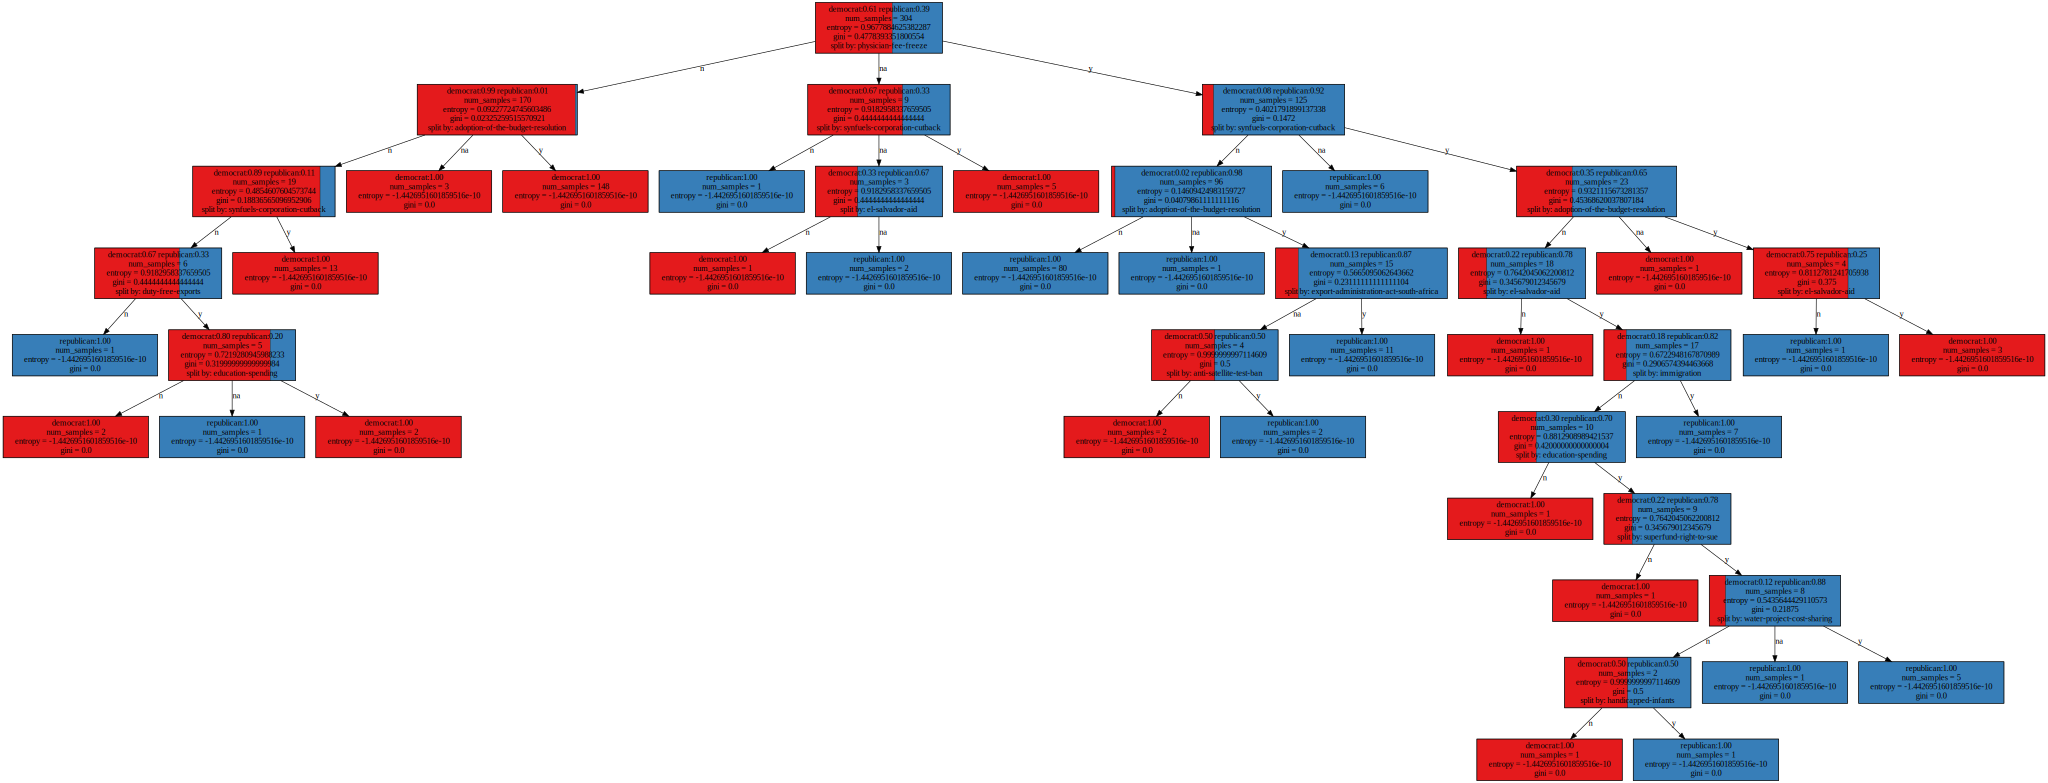

In [0]:
TODO

# TODO: Build and draw the tree


Unpruned err rate: 0.07633587786259544
Pruned err rate: 0.04580152671755722


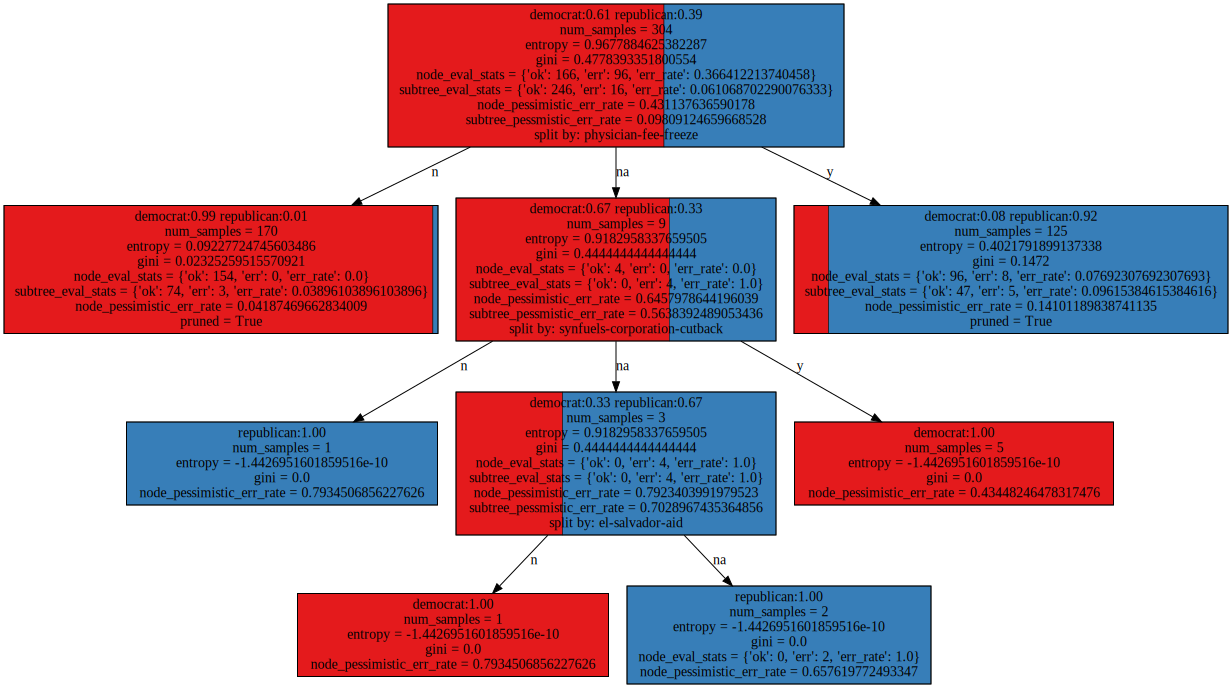

In [0]:
# TODO: implement a pruning method of your choice



# Problem 4: Random Forest [3p]

We will use the german credit dataeset. Please split it into a traiing and testing set using a 70%-30% ratio.

Then train and test a regular decision tree on it.

Then:
1. Implement selecting the split from a small random selection of attriutes.
2.  Build a forest of at least 20 Random Trees, each selecting splits out of 1-3 attributes on the German Credit data. After adding each random tree:
    - Compute its test error rate and its OOB error rate
    - Record the accurracy of the RF after adding the tree to it. 
    
    At the end ot training record the forest's OOB error rate.


What is the mean accurracy of individual trees in the forest? What is the final forest accurracy? 

Define the agreement between two trees to be the fraction of test samples on which the answer of the two trees is identical. What is the mean aggreement of trees in the forest? How does it change with the number of attributes considered for each split? What is the impact of training each tree in the forest on a bootstrap sample, rather than on the train set?

Unpruned err rate: 0.3466666666666667
Pruned err rate: 0.32666666666666666


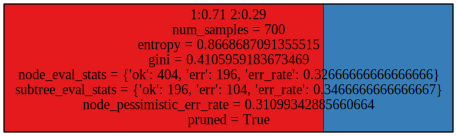




nattr: 1
Tree 0: RF Err rate 0.377    Err rate 0.377 OOB err rate 0.301
Tree 1: RF Err rate 0.330    Err rate 0.333 OOB err rate 0.385
Tree 2: RF Err rate 0.293    Err rate 0.307 OOB err rate 0.350
Tree 3: RF Err rate 0.317    Err rate 0.403 OOB err rate 0.346
Tree 4: RF Err rate 0.313    Err rate 0.423 OOB err rate 0.446
Tree 5: RF Err rate 0.303    Err rate 0.300 OOB err rate 0.331
Tree 6: RF Err rate 0.307    Err rate 0.320 OOB err rate 0.314
Tree 7: RF Err rate 0.297    Err rate 0.390 OOB err rate 0.373
Tree 8: RF Err rate 0.300    Err rate 0.373 OOB err rate 0.402
Tree 9: RF Err rate 0.310    Err rate 0.367 OOB err rate 0.342
Tree 10: RF Err rate 0.297    Err rate 0.343 OOB err rate 0.430
Tree 11: RF Err rate 0.290    Err rate 0.393 OOB err rate 0.349
Tree 12: RF Err rate 0.293    Err rate 0.360 OOB err rate 0.314
Tree 13: RF Err rate 0.293    Err rate 0.327 OOB err rate 0.335
Tree 14: RF Err rate 0.297    Err rate 0.363 OOB err rate 0.357
Tree 15: RF Err rate 0.290    Err rate

# Problem 5 [3bp]

Implement the following extra analysis using a Random Forest:
- variable importance
- data clustering
- data visualizatoin using MultiDimensional Sclaing (https://en.wikipedia.org/wiki/Multidimensional_scaling, https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html).

For details see https://www.stat.berkeley.edu/~breiman/Using_random_forests_v4.0.pdf.